## European and American put option pricing w/ real data
---

* A. Du Preez (14936755)
* K.M. Disselkamp (14928566)

# Preface
---

We are considering the Endava stock and a put option on said stock. The option contract was entered on 26.01.2024, from now denoted $t = 0$, at strike price $K = 85.00$ USD and reaches maturity on 16.08.2024 (denoted $T$). The stock price at initialization was $S_0 = 74.09$ USD. There are 28 open interests in the option.

In [26]:
#Imports
#----------------------------------
from binomialTree import *
from parameter_estimations import *
import matplotlib.pyplot as plt
from implied_volatility import *

In [27]:
#Parameters
#----------------------------------

S_0 = 74.09 #Real stock price
K = 85.00 #Real strike price

weeks = 31 # weeks until expiry
days = 5 # days in a regular trading week
holidays = 5 # 19.02, 29.03, 27.05, 19.06, 04.07 (https://www.nyse.com/markets/hours-calendars)
tradingdays = 252

T = (weeks*days - holidays) / tradingdays

R = 0.0522 # (https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_bill_rates&field_tdr_date_value=2024)
r = np.log(1 + R) #continuously compounded interest rate 

market_price = 14.70 #Market price of put option

stock_prices = caluclate_stock_returns() #Stock returns
vol = estimate_volatility(stock_prices) #Historical volatility
sigma = np.sqrt(vol) #Standard deviation


## Question 2
---

* Binomial estimate

In [28]:
tree = build_tree(S_0, sigma, T, 50)
value_EU_put = EuropeanPutOption(tree, T, r, K, sigma) [0][0]
print(f"Estimated value of EU put using Binomial tree with 500 steps: {value_EU_put}")

Estimated value of EU put using Binomial tree with 500 steps: 20.404738538206473


* Black Scholes solution

In [29]:
Ns = np.arange(1, 101)
n_steps = (weeks*days) - holidays


binom_ests = []
bs_ests = []


# loop through number of steps and estimate approximation error
for N in Ns:
    
    # binomial tree
    tree = build_tree(S_0, sigma, T, N)
    value_EU_put = EuropeanPutOption(tree, T, r, K, sigma)
    binom_ests.append(value_EU_put[0,0])

    # black-scholes
    value_EU_put_bs = BlackScholesPut(S_0, T, r, sigma, K, n_steps)
    bs_ests.append(value_EU_put_bs)

differences = np.abs(np.array(binom_ests) - np.array(bs_ests))


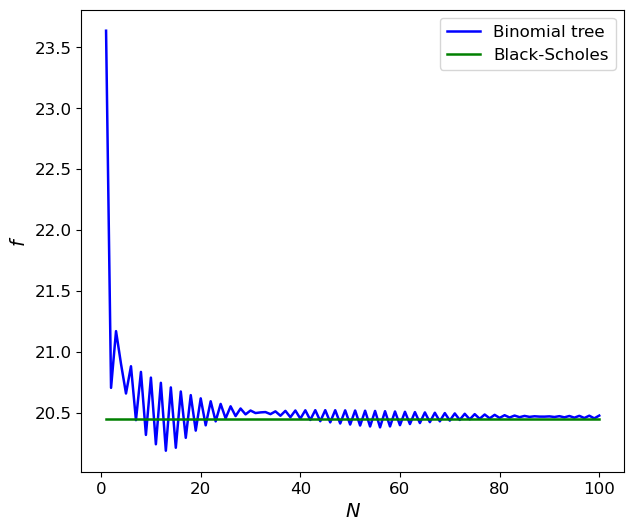

In [30]:
plt.figure(figsize=(7, 6))
plt.plot(Ns, binom_ests, label='Binomial tree', linestyle='-', linewidth=1.8, color = "b")
plt.plot(Ns, bs_ests, label='Black-Scholes', linestyle='-', linewidth=1.8, color = "green")
plt.xlabel('$N$', fontsize=14)
plt.ylabel('$f$', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig("plots/EU Put Option Convergence", dpi = 300)
plt.show()

## Question 3
---

* Calculate the value of an American put option based on a binomial tree with 3 layers

In [31]:
N = 500
initTree = build_tree(S_0, sigma, T, N)
AmericanOptionPrice = AmericanPutOption(initTree, T, r, K, sigma)
print('An American put option under the given settings is valued at', AmericanOptionPrice[0,0])


An American put option under the given settings is valued at 20.820395483454977


In [32]:
threeTree = build_tree(S_0, sigma, T, 3)
AmericanThreeTree = AmericanPutOption(threeTree, T, r, K, sigma)
print(AmericanThreeTree)

[[21.43088449  0.          0.          0.        ]
 [31.60602306  9.12244408  0.          0.        ]
 [44.15816614 16.54063976  0.          0.        ]
 [54.67658888 29.99116916  0.          0.        ]]


* Calculate the value of the European counterpart for 3 layers

In [33]:
EuropeanThreeTree = EuropeanPutOption(threeTree, T, r, K, sigma)
print(EuropeanThreeTree)

[[21.17117354  0.          0.          0.        ]
 [31.13512018  9.12244408  0.          0.        ]
 [43.3043341  16.54063976  0.          0.        ]
 [54.67658888 29.99116916  0.          0.        ]]


In [34]:
print(AmericanThreeTree - EuropeanThreeTree)

[[0.25971095 0.         0.         0.        ]
 [0.47090289 0.         0.         0.        ]
 [0.85383204 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


* Convergence of the American put option price

In [35]:
layers = np.arange(5, 500, 1.0)

AmericanOption = []
EarlyExercise = []
for Nlayers in layers:
    Tree = build_tree(S_0, sigma, T, int(Nlayers))
    Price = AmericanPutOption(Tree, T, r, K, sigma)[0,0]
    EU_price = EuropeanPutOption(Tree, T, r, K, sigma)[0,0]
    AmericanOption.append(Price)
    EarlyExercise.append(Price - EU_price)

In [36]:
print('For 500 layers the American option is valued at', AmericanOption[-1])
print('The difference between the last and second to last layer is', AmericanOption[-2])
print('For 500 layers the value of early exercise is', EarlyExercise[-1])
print('The mean of all approximations is', np.mean(np.array(AmericanOption)))

For 500 layers the American option is valued at 20.832320650990496
The difference between the last and second to last layer is 20.820639001082213
For 500 layers the value of early exercise is 0.37385578681122666
The mean of all approximations is 20.839062992448856


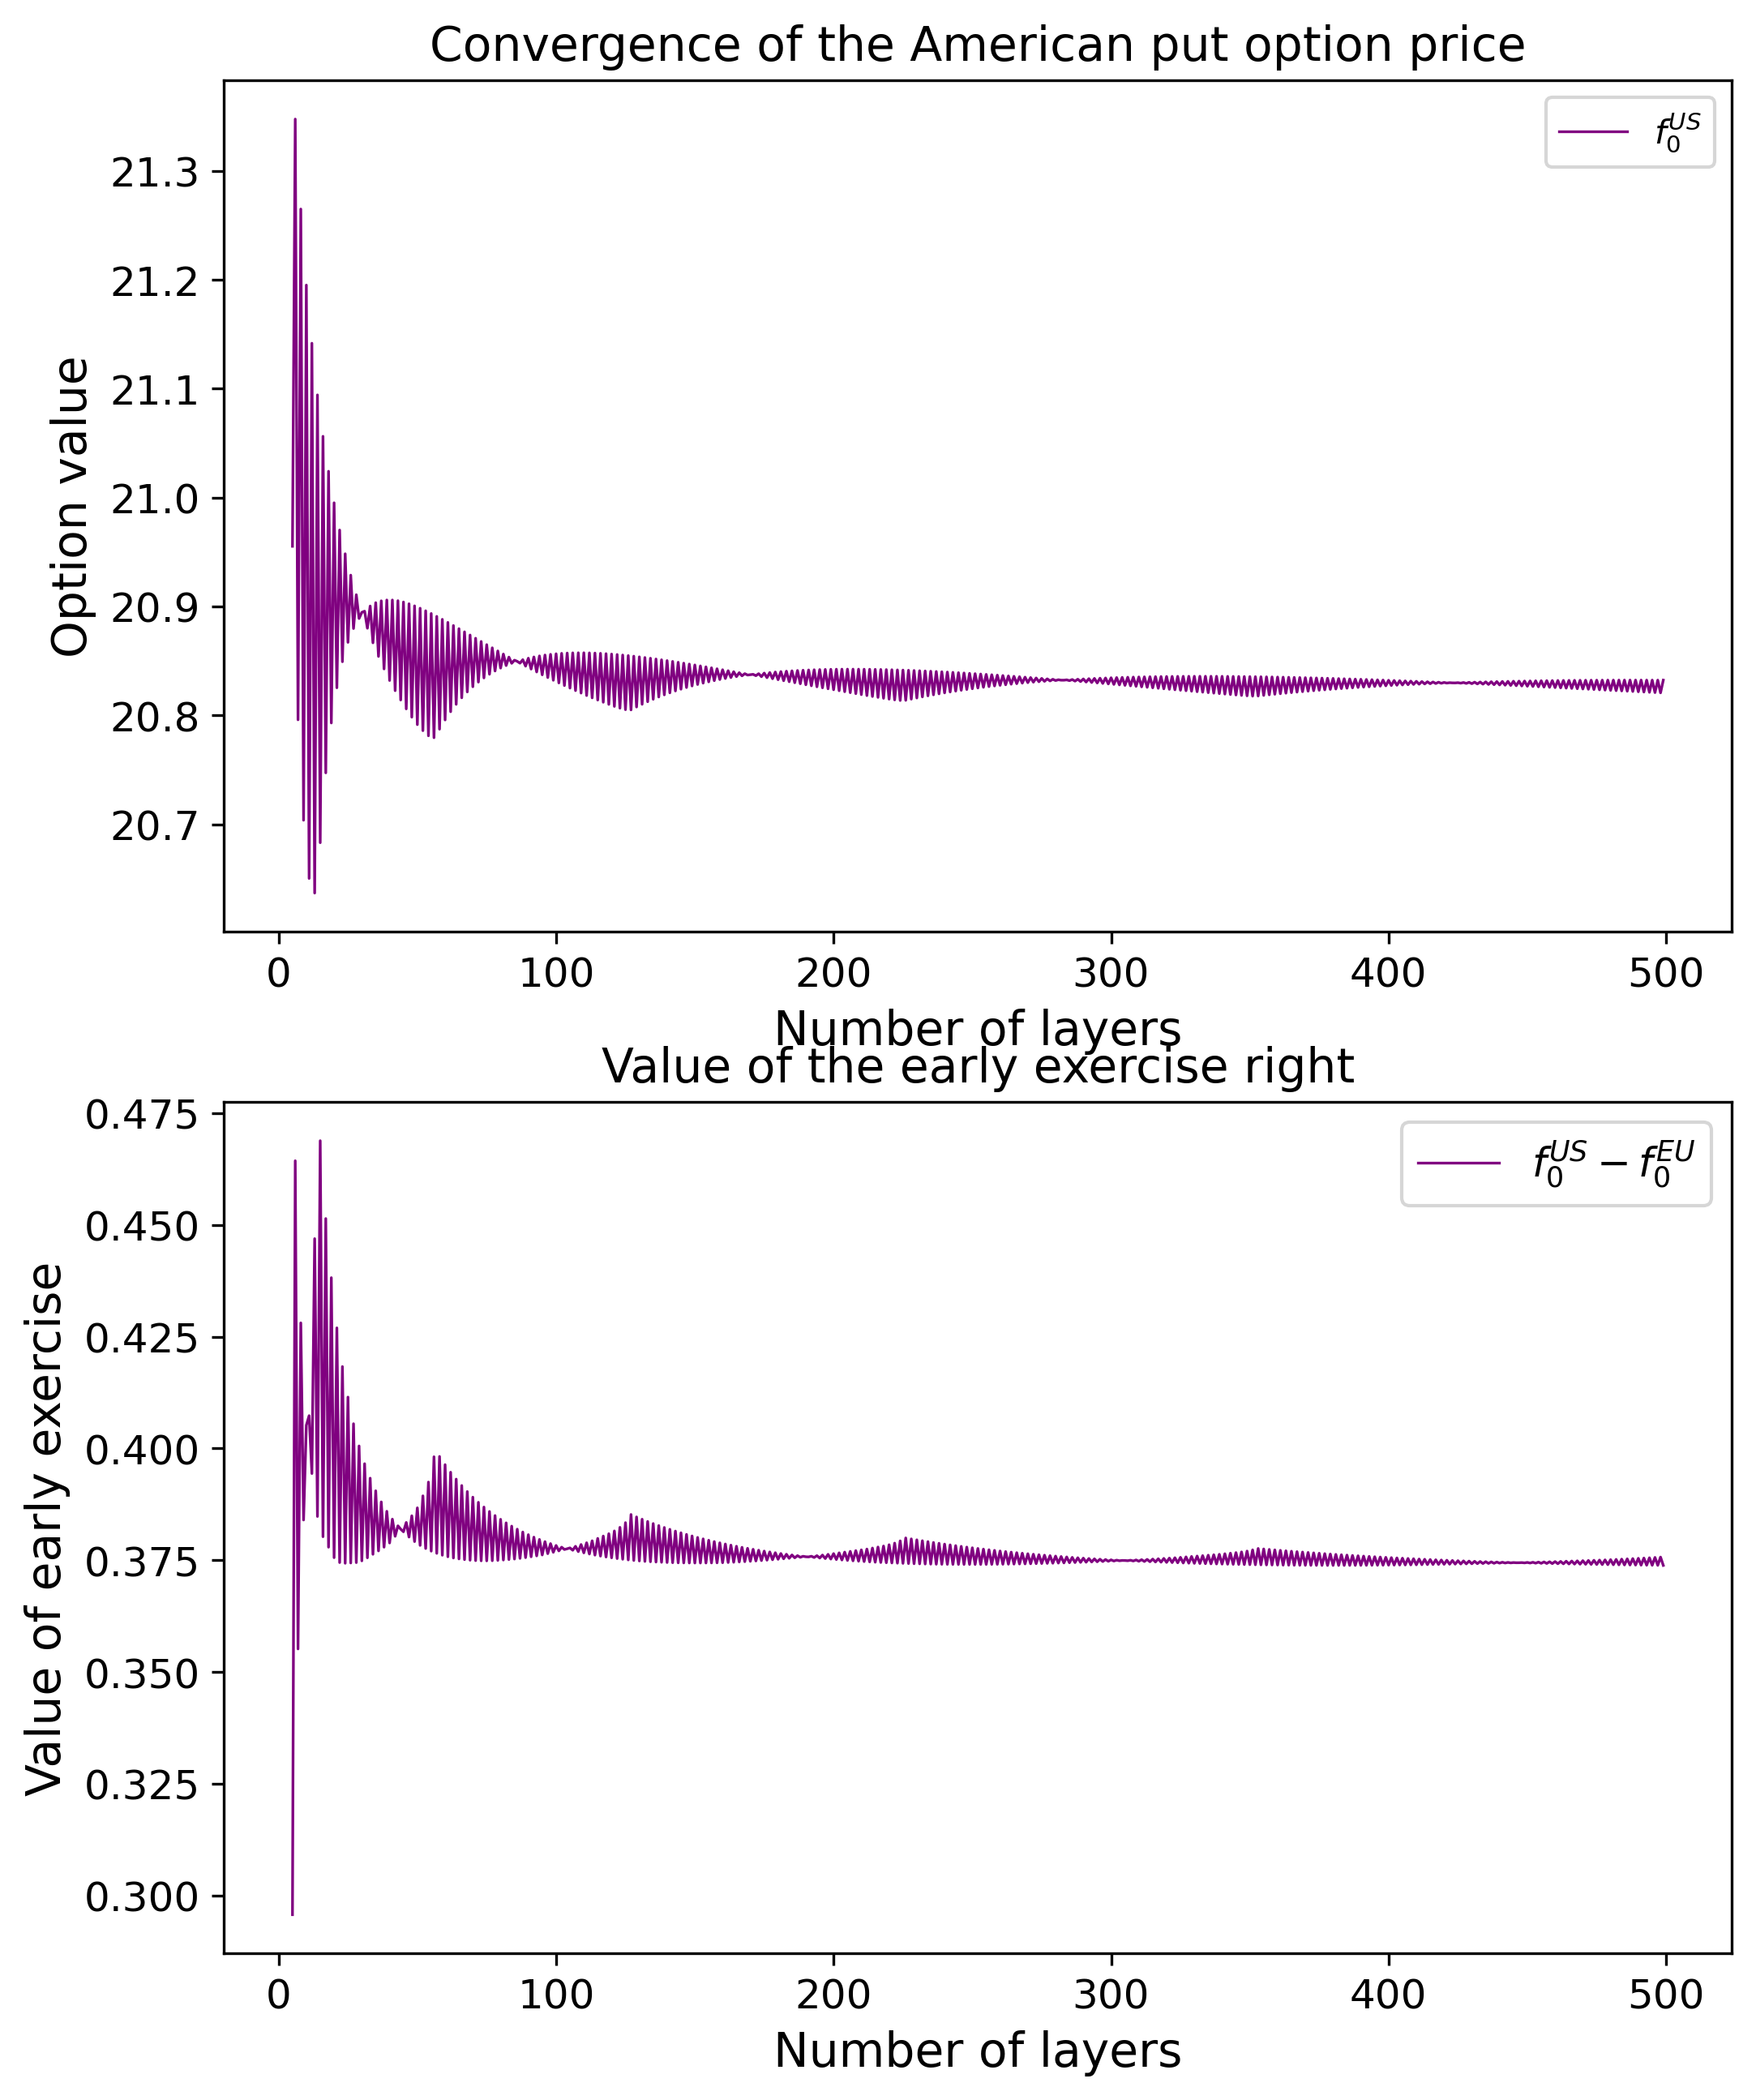

In [37]:
plt.figure(dpi = 300, figsize = (8, 10))
plt.subplot(211)
plt.plot(layers, AmericanOption, linewidth = '0.8', color = 'purple', label = '$f_0^{US}$')
plt.legend()
plt.xlabel('Number of layers', fontsize=14)
plt.ylabel('Option value', fontsize=14)
plt.title('Convergence of the American put option price', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.subplot(212)
plt.plot(layers, EarlyExercise, linewidth = '0.8', color = 'purple', label = '$f_0^{US} - f_0^{EU}$')
plt.legend()
plt.xlabel('Number of layers', fontsize=14)
plt.ylabel('Value of early exercise', fontsize=14)
plt.title('Value of the early exercise right', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()
plt.close()

In [38]:
layer = 150
tolerance = 10**(-5)
max_iters = 1000

iters = 0
tol = 100

Tree_old = build_tree(S_0, sigma, T, layer-1)
Price_old = AmericanPutOption(Tree_old, T, r, K, sigma)[0,0]

while (tol > tolerance and iters < max_iters):
    Tree_new = build_tree(S_0, sigma, T, layer)
    Price_new = AmericanPutOption(Tree_new, T, r, K, sigma)[0,0]
    
    tol = abs(Price_new - Price_old)
    iters = iters + 1
    layer = layer + 1
    
    Price_old = Price_new
    
print(layer)

284


* Effect of the interest rate $r$ on the value of early exercise

In [39]:
stockTree = build_tree(S_0, sigma, T, N)

OptionPrice = []
OptionPrice_EU = []
ExerciseValue = []

interest_variations = np.arange(0, 1.6, 0.05)
for interest in interest_variations:
    US_Price = AmericanPutOption(stockTree, T, interest, K, sigma)[0,0]
    EU_Price = EuropeanPutOption(stockTree, T, interest, K, sigma)[0,0]
    
    
    OptionPrice.append(US_Price)
    OptionPrice_EU.append(EU_Price)
    ExerciseValue.append(US_Price - EU_Price)

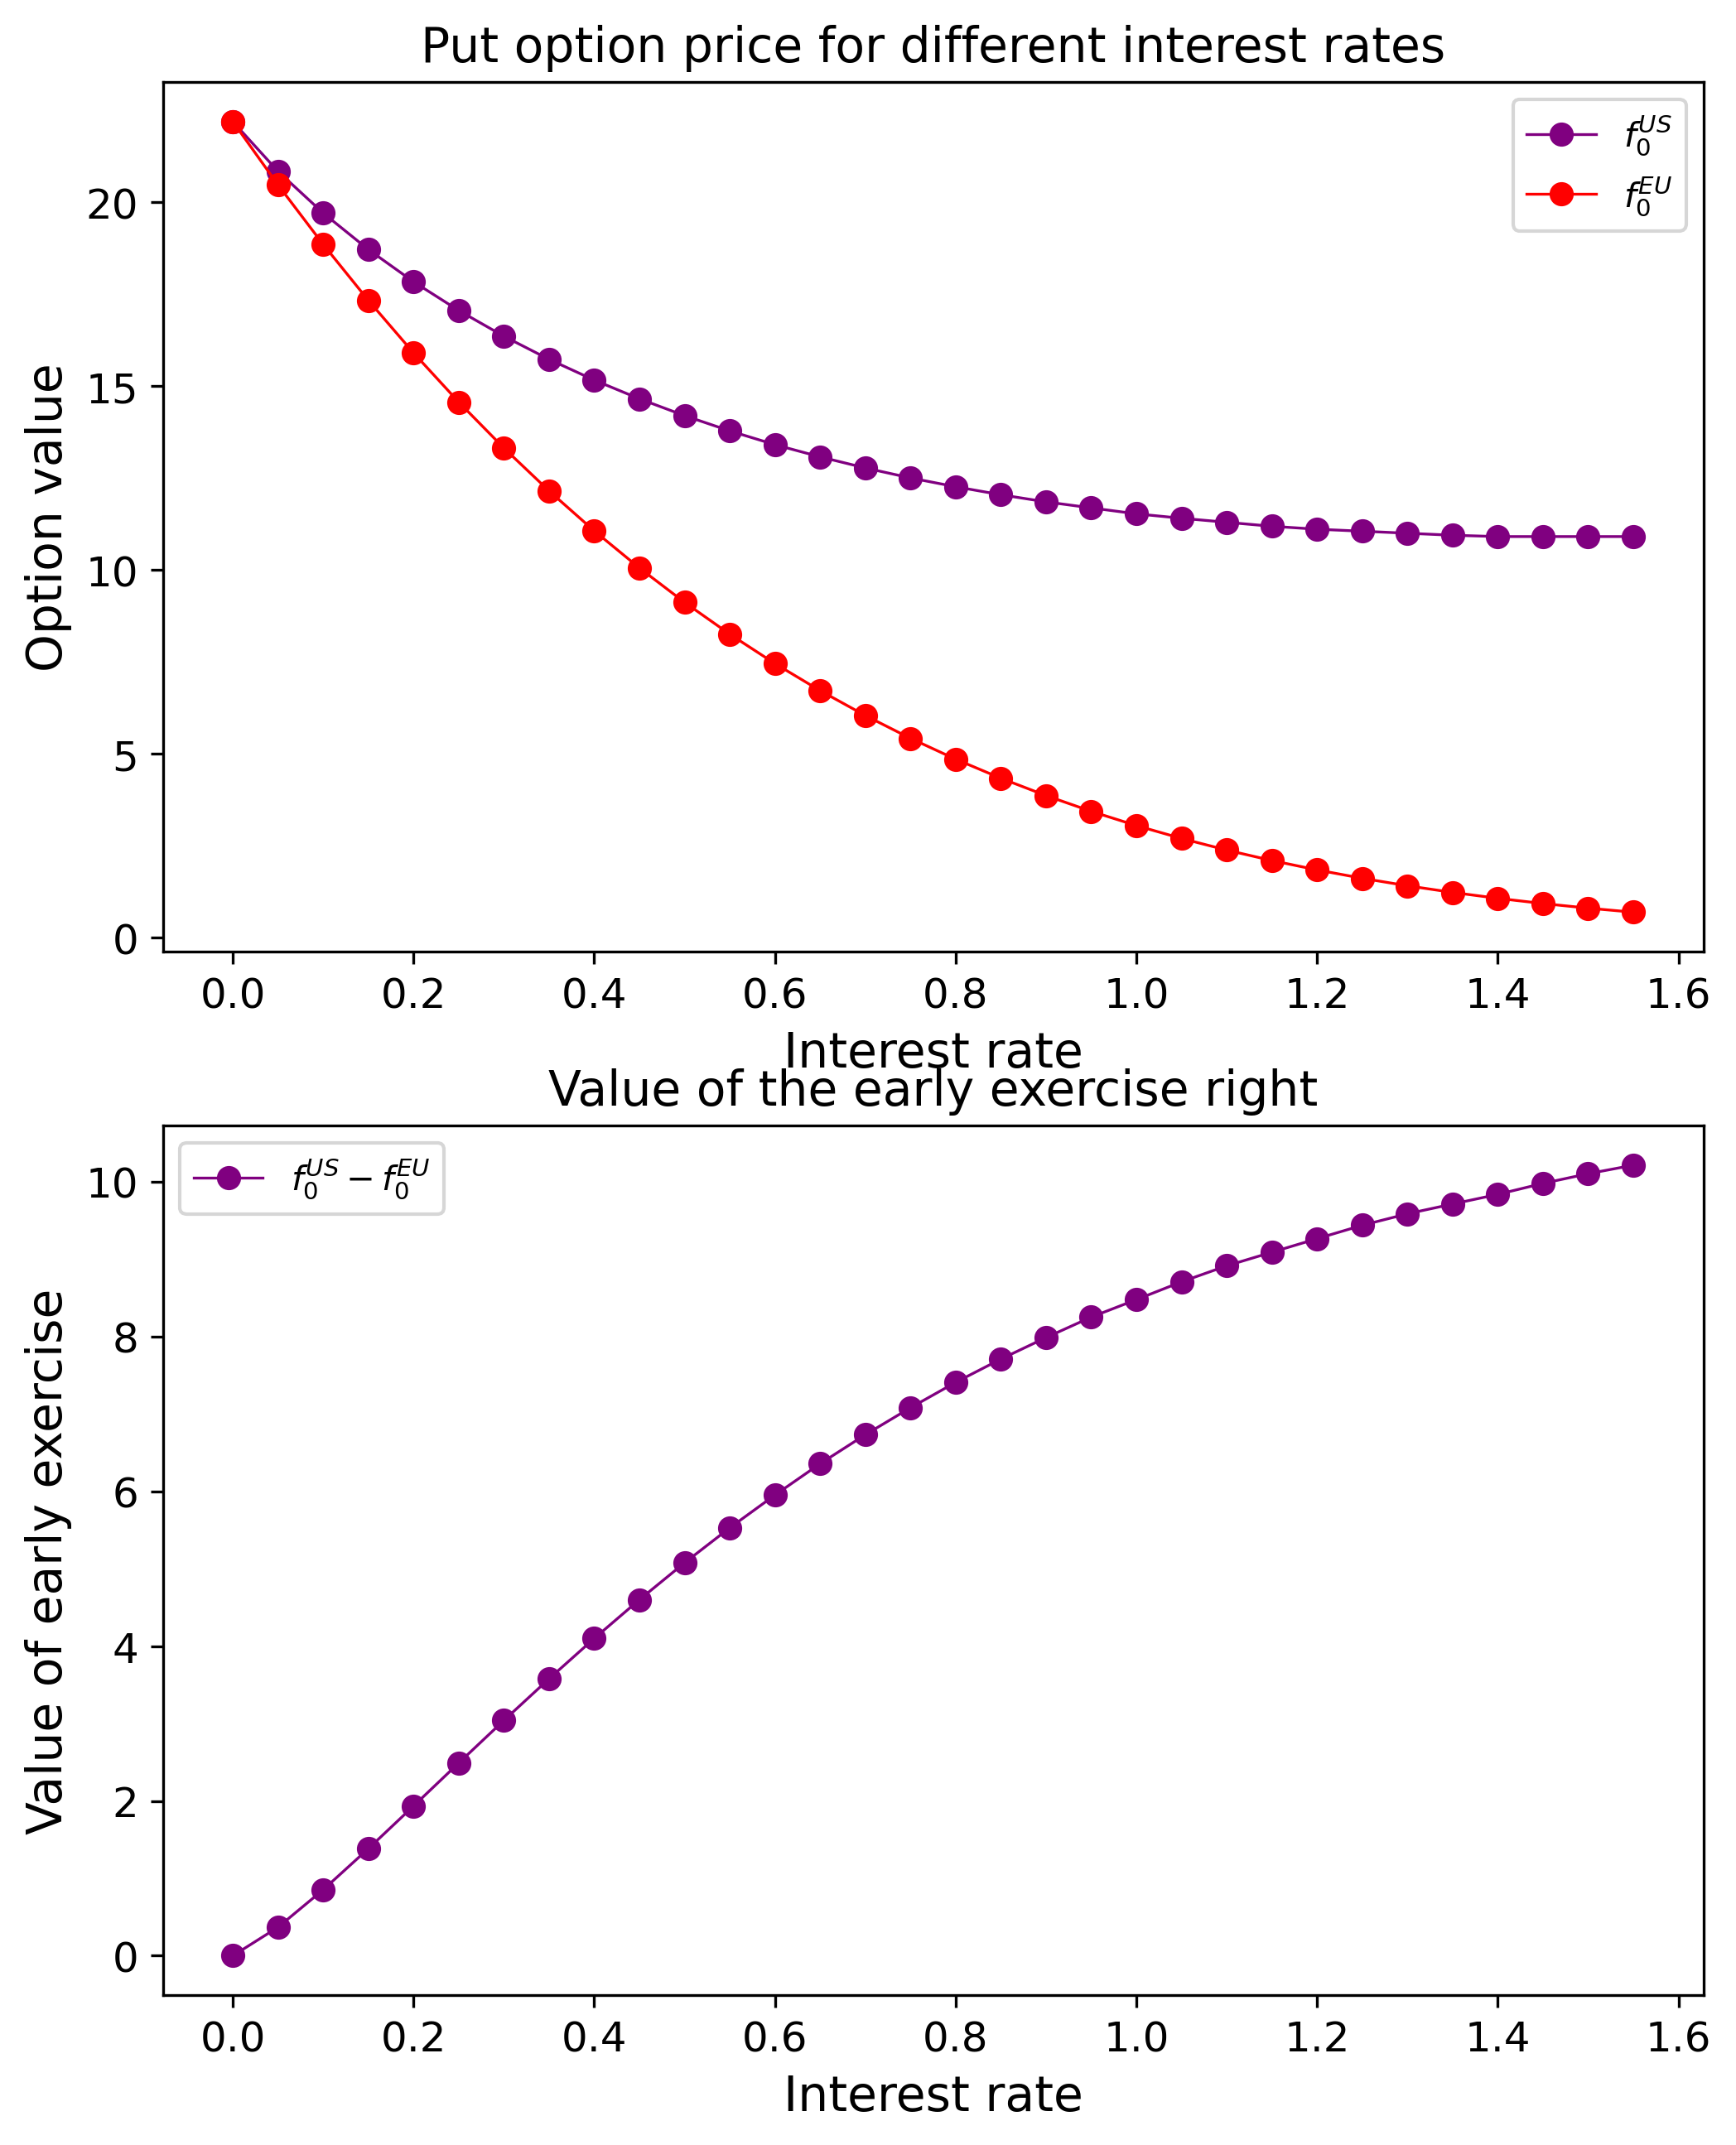

In [40]:
plt.figure(dpi = 300, figsize = (8, 10))
plt.subplot(211)
plt.plot(interest_variations, OptionPrice, linewidth = '0.8', color = 'purple', marker = 'o', label = '$f_0^{US}$')
plt.plot(interest_variations, OptionPrice_EU, linewidth = '0.8', color = 'red', marker = 'o', label = '$f_0^{EU}$')
plt.legend()
plt.xlabel('Interest rate', fontsize=14)
plt.ylabel('Option value', fontsize=14)
plt.title('Put option price for different interest rates', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.subplot(212)
plt.plot(interest_variations, ExerciseValue, linewidth = '0.8', color = 'purple', marker = 'o', label = '$f_0^{US} - f_0^{EU}$')
plt.legend()
plt.xlabel('Interest rate', fontsize=14)
plt.ylabel('Value of early exercise', fontsize=14)
plt.title('Value of the early exercise right', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()
plt.close()

## Question 4
-----


* Compute American option price with historical volatility

In [41]:
tree = build_tree(S_0, sigma, T, 100)
price = AmericanPutOption(tree, T, r, K, sigma)[0,0]
print(f"Theoretical price of American option: {price}")

Theoretical price of American option: 20.856532061721335


* Compute American option price with implied volatility

In [42]:
iterations = 100
implied_volatility, theoretical_prices = compute_implied_volatility(tree, T, r, K, sigma, market_price,iterations)
print(f"Computed implied volatility: {implied_volatility}")

Computed implied volatility: 0.09089096158941301


* Determine convergence of theoretical price to market price

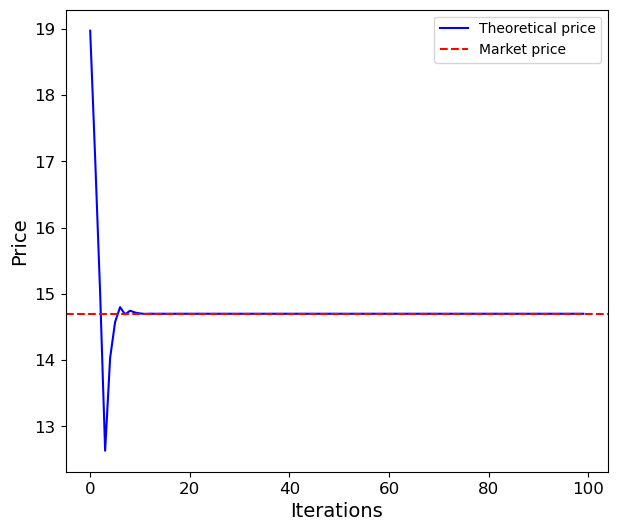

In [43]:
plt.figure(figsize=(7, 6))
plt.plot(np.arange(0,iterations), theoretical_prices, label = "Theoretical price" , color = "b")
plt.axhline(market_price, linestyle = "--", label = "Market price", color = "red")
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig("plots/Theoretical-convergence", dpi = 300)
plt.legend()
